<font size="6">Introduction to Decision Trees</font>

Francisco Förster Burón

LSSDS 2021

**Bibliography**: 

* Statistics, Data Mining, and Machine Learning in Astronomy: A Practical Python Guide for the Analysis of Survey Data (Princeton Series in Modern Observational Astronomy). Željko Ivezic, Andrew J. Connolly, Jacob T VanderPlas, Alexander Gray.

* The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Trevor Hastie, Robert Tibshirani, Jerome Friedman.

* Modern Statistical Methods for Astronomy - with R Applications.Eric Feigelson G. Jogesh Babu

Load some libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

<font size="4"> **What is the decision boundary for the following design matrix?** </font>

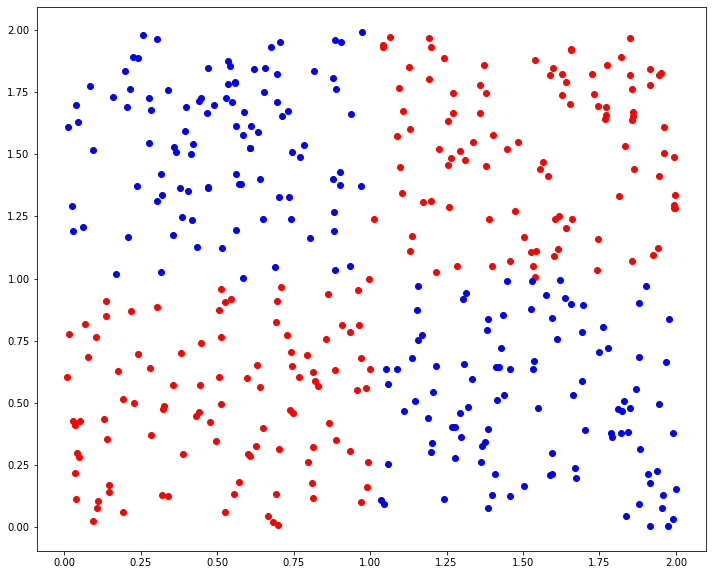

In [3]:
fig, ax = plt.subplots(figsize = (12, 10))
ax.scatter(np.random.random(100), np.random.random(100), c = 'r')
ax.scatter(1 + np.random.random(100), 1 + np.random.random(100), c = 'r')
ax.scatter(np.random.random(100), 1 + np.random.random(100), c = 'b')
ax.scatter(1 + np.random.random(100), np.random.random(100), c = 'b')

An extension of classification methods based on modelling the boundary between classes are the **decision trees**, which model the decision boundary in a hierarchical fashion

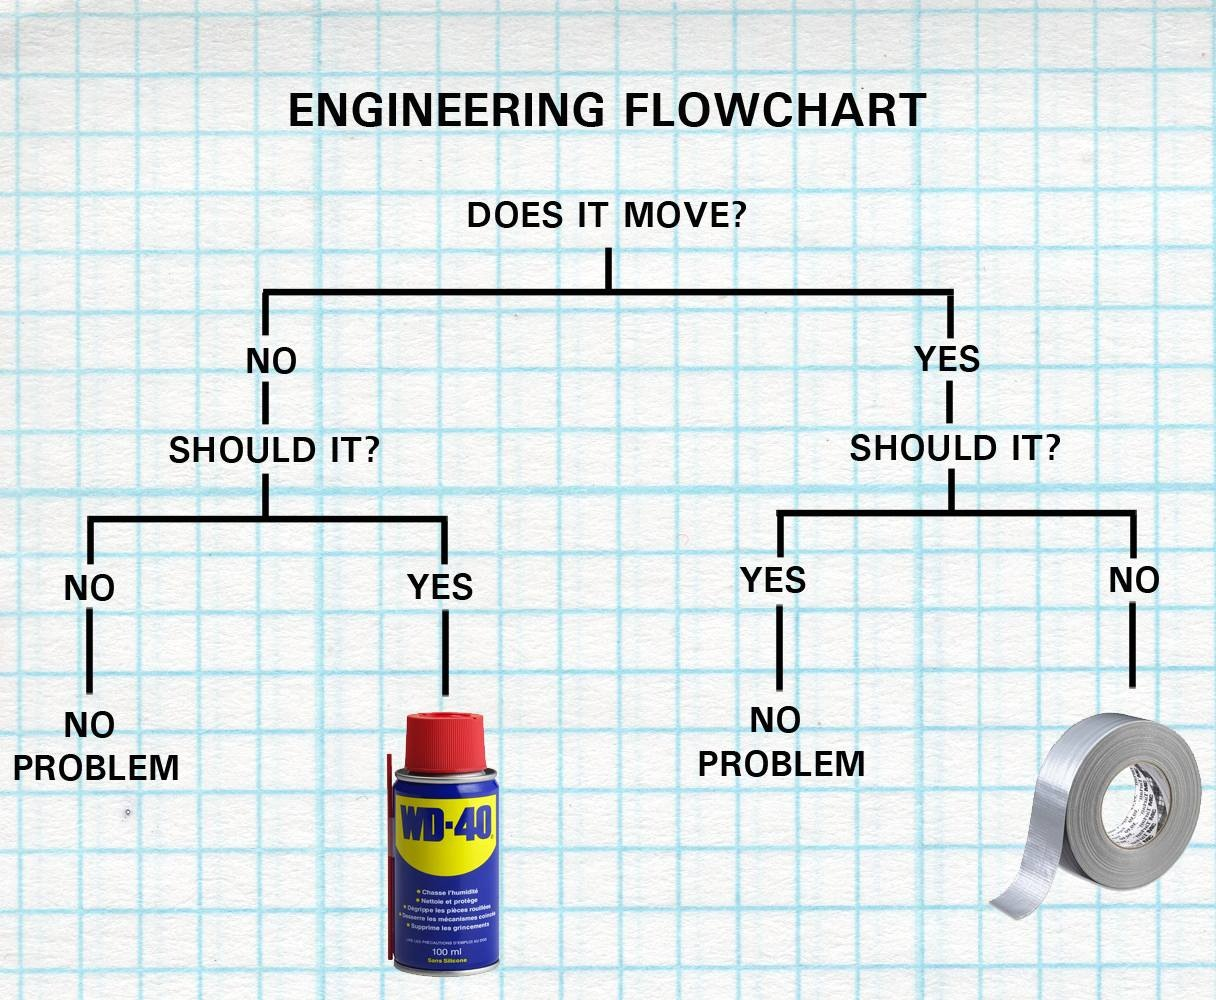![](images/sorted.jpg)

The advantage of this model is the *interpretability*, the model can be understood in simple terms.

<font size="5"> **Tree based methods** </font>

* the feature space is partitioned into a set of hyper cubes, then a class (classifier) or a value (regression) is assigned to each region in the partition. 

<font size="4">The problem is usually reduced to finding the optimal partition of the parameter space.</font>

To simplify this problem, only binary partitions are allowed: we split the space into regions determined by one value and dimension at a time.

![](images/partition.png)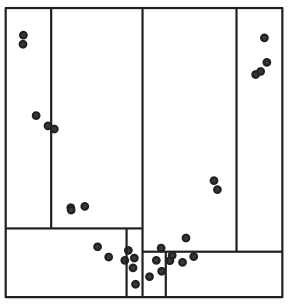
<div align='right'> Credit: Ivezic+2014 </div>

# Regression Trees

Let us say we have M regions and assign a constant inside each region of the partition:

$ \Large \hat{f}(x) = \sum\limits_{m=1}^{M} c_m I(x \in R_m)$

One can show that the best value for $c_m$ if one wants to minimize the sum of residuals $\sum(y_i - f(xi))^2$ is the average of $y_i$ inside the region $R_m$:

$\Large \hat{c}_m = avg(y_i | x_i \in R_m)$

Finding the optimal partition is a difficult problem and is usually computationally unfeasible. Thus, a greedy algorithm is normally used.

Consider a splitting variable $j$ and a split point $s$ and define the pair of half planes:

$\Large R_1(j, s) = \lbrace X | X_j \le s\rbrace  ~~~~ {\rm and} ~~~ R_2(j, s) = \lbrace X | X_j > s\rbrace$

Then, we want to find the split variable $j$ and split point $s$ that solve:

$\Large \min\limits_{j, s} \biggl[ \min\limits_{c_1} \sum\limits_{x_i \in R_1(j, s)} (y_i - c_1)^2 + \min\limits_{c_2} \sum\limits_{x_i \in R_2(j, s)} (y_i - c_2)^2 \biggr]$

For any choice of $j$ and $s$, the optimal values for $c_1$ and $c_2$  is:

$\Large c_1 = avg(y_i | x_i \in R_1(j, s)~~~~  {\rm and}~~~ c_2 = avg(y_i | x_i \in R_2(j, s) $

## Tree pruning

One must decide when to stop growing decision trees not to overfit the data.

A simple solution would be to stop splitting the tree if the decrese in residuals does not exceed some threshold. This can be too short sighted, since a subsequent split may lead a to large decrease in the residuals.

A typical strategy is to grow the tree up to when a minimum node size is reached. Then, the tree is pruned using **cost-complexity pruning**.

### Cost-complexiy pruning

Let us define the tree $T \subset T_0$, where $T_0$ is the original tree to prune.

Terminal nodes or leaves are identified by index $m$, with leaf $m$ representing region $R_m$.

Let $|T|$ denote the **number of leaves** in $T$.

Let us define:

$\Large N_m = \#\lbrace x_i \in R_m \rbrace$

$\Large \hat{c}_m = \frac{1}{N_m} \sum\limits_{x_i \in R_m} y_i$

$\Large Q_m(T) = \frac{1}{N_m} \sum\limits_{x_i \in R_m} (y_i - \hat{c}_m)^2$


we define the cost complexity criterion

$\Large C_\alpha(T) = \sum\limits_{m=1}^{|T|} N_m Q_m(T) + \alpha |T|$

For each $\alpha$ we must find the subtree $T_\alpha \subset T_0$ which minimizes $C_\alpha(T)$.

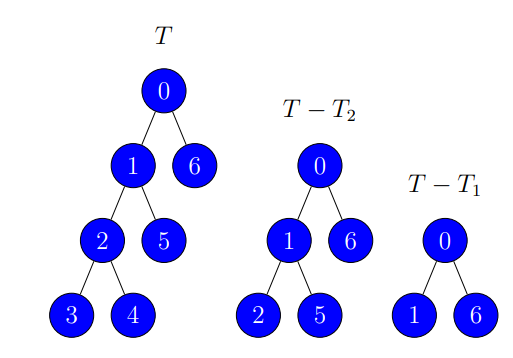
<div align="right"> Credit: Kiran & Serra 2017 https://arxiv.org/pdf/1703.05430.pdf </div>

The parameter $\alpha$ controls the tradeoff between model complexity (the tree size) and the goodness-of-fit, or the bias-variance tradeoff.

#### Algorithm to find $T_\alpha$:


1. Collapse the internal node (where a split happens) that produces the smallest per node increase in $\sum_m N_m Q_m(T)$. 

2. Continue until all nodes are collapsed, producing a sequence of subtrees.

3. <font size="3"> One can show that the tree $T_\alpha$ which minimizes $C_\alpha(T)$ must be among the previous sequence of subtrees! (Breiman et al. 1984). </font>

In order to estimate $\alpha$ five or ten fold cross-validation can be used.

See examples in https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#:~:text=Cost%20complexity%20pruning%20provides%20another,the%20number%20of%20nodes%20pruned.

Note that in scikit-learn the parameter $\alpha$ is given by `ccp_alpha`, which is by default = 0

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


A different approach to prunning is using cross-validation, as will be shown below.

# Classification trees

For regression, the squared error residuals are used as impurity measure $Q_m(T)$, but for classification we need to change the impurity measure.

Let us denote the proportion of class $k$ observations in node $m$ as:

$\Large \hat{p}_{mk} = \frac{1}{N_m} \sum\limits_{x_i \in R_m} I(y_i = k)$.

And let us assume that the observations in node $m$ are classified as class 

$\Large k(m) = {\rm argmax}_k \hat{p}_{mk}$.

## Impurity measures

We can now use different measures of $Q_m(T)$ as node impurity:

* **The misclassification error**:

$\Large \frac{1}{N_m} \sum\limits_{i \in R_m} I(y_i \ne k(m)) = 1 - \hat{p}_{mk}(m)$.

* **The Gini index**:

$\Large \sum\limits_{k \ne k'} \hat{p}_{mk} \hat{p}_{mk'} = \sum\limits_{k=1}^{K} \hat{p}_{mk} (1 - \hat{p}_{mk})$.

* **The cross-entropy or deviance**:

$\Large -\sum\limits_{k=1}^K \hat{p}_{mk} \log \hat{p}_{mk}$.

The behaviour of this three types of impurity measures can be visualizad in a two class classifier where the proportion of the first class is p. 

Let us first compute the $\hat{p}_{mk}$ values:

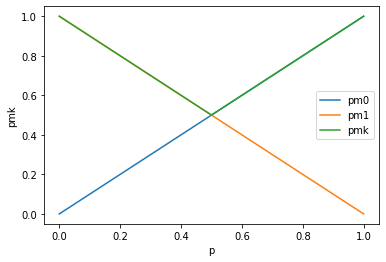

In [4]:
fig, ax = plt.subplots()

ps = np.linspace(0, 1, 1000)
pm0 = ps
pm1 = 1 - ps
pmk = np.maximum(pm0, pm1)

ax.plot(ps, pm0, label = 'pm0')
ax.plot(ps, pm1, label = 'pm1')
ax.plot(ps, pmk, label = 'pmk')
ax.set_xlabel("p")
ax.set_ylabel("pmk")
ax.legend()

Let us know plot the three types of impurity measures:

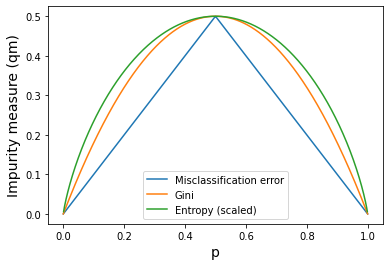

In [5]:
fig, ax = plt.subplots()

# misclassification error
qm = 1 - pmk
ax.plot(ps, qm, label="Misclassification error")

# gini 
qm = pm0 * (1 - pm0) + pm1 * (1 - pm1)
ax.plot(ps, qm, label="Gini")

# entropy (we ignore the first and last values of p)
qm = -(pm0[1:-1] * np.log(pm0[1:-1]) + pm1[1:-1] * np.log(pm1[1:-1]))
ax.plot(ps[1:-1], qm / np.max(qm) * 0.5, label="Entropy (scaled)")

ax.set_xlabel("p", fontsize=14)
ax.set_ylabel("Impurity measure (qm)", fontsize=14)
ax.legend()

The Gini and entropy impurity measures are differentiable and easier to optimize. They are therefore recommended.

## Example 

Let us look at the example from Ivezic et al. 2014. Here a sample of non-variable stars and RR Lyrae stars are characterized by their colors and a tree is built to classify them.

![](images/tree_2.png)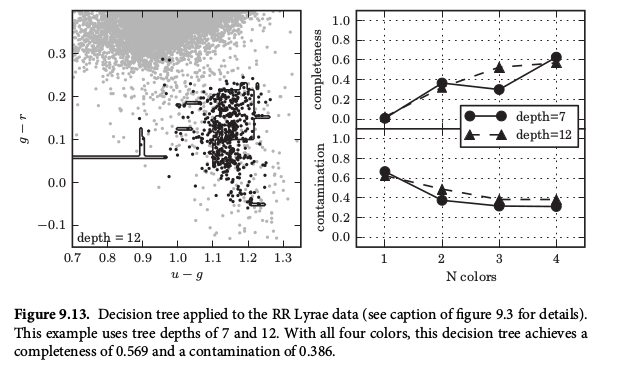

<div align="right"> Credit: Ivezic et al. 2014 </div>

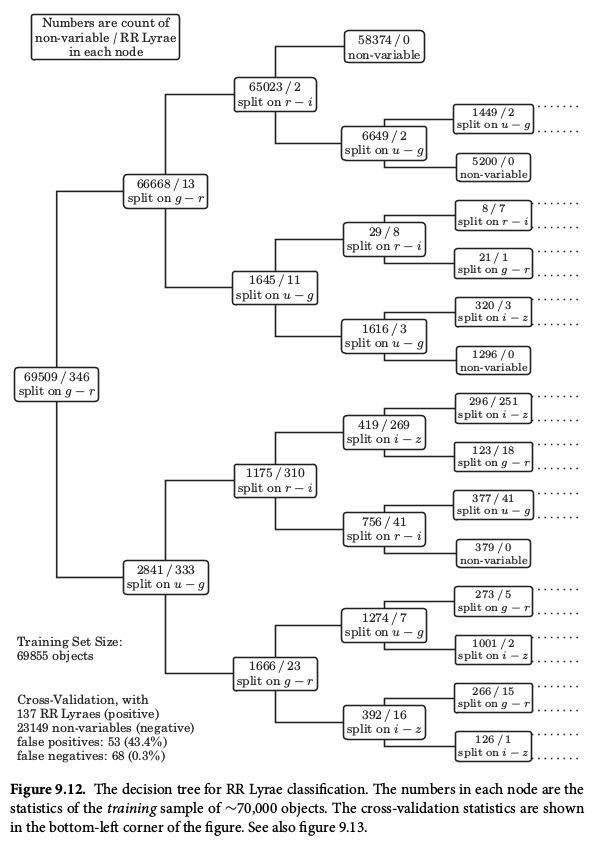
<div align="right"> Credit: Ivezic et al. 2014 </div>

At each node the fraction of points within the node in each class is annotated


The difficulty in building a tree is which feature to choose and the value for splitting in each node. 

In the example above the splitting criterion was based on entropy:


$\Large E(x) = -\sum\limits_i p_i(x) \ln(p_i(x))$


where $i$ is the class and $p_i(x)$ is the probability of that class given the training data.

Let's compute the entropy at the first node split:

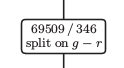

Let's define a function to compute the entropy.

In [6]:
def E(n1, n2):
    p1 = n1 / (n1 + n2)
    p2 = n2 / (n1 + n2)
    return -(p1 * np.log(p1) + p2 * np.log(p2))

Entropy of the split when 69509 elements are on one branch and 346 on the other:

In [7]:
print(E(69509, 346))

0.031230679249027685


It is a low entropy split, which is what we want.

Imagine if the split had been 49509 and 20346 instead:

In [8]:
print(E(49509, 20346))

0.6032764307951708


This is a higher entropy split, i.e. it is not very informative.

We can define **information gain** as the reduction of entropy due to the partitioning of the data (the difference between the entropy of the parent node and the sum of the entropies of the child nodes).


For a binary split with $i=0$ representing points below the threshold and $i=1$ above the split threshold, the information gain $IG$ is:

$\Large IG(x|x_i) = E(x) - \sum\limits_{i=0}^{1} \frac{N_i}{N} E(x_i)$


where $N_i$ is the number of points, $x_i$, in class  $i$, and $E(x)$ is the entropy associated with that class.

In the example above the information gain after the first split is: 

![](images/split.png)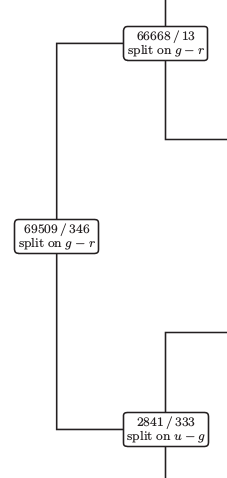



In [9]:
n1 = 69509
n2 = 346
n1_1 = 66668
n2_1 = 13
n1_2 = 2841
n2_2 = 333
IG = E(n1, n2) \
    - (n1_1 + n2_1) / (n1 + n2) * E(n1_1, n2_1) \
    - (n1_2 + n2_2) / (n1 + n2) * E(n1_2, n2_2)
print(IG)

0.01419933827960912


Finding the optimal splits is considered computationally intractable. 

The search for the split is done in a *greedy* fashion, i.e. each feature is considered one at a time and the feature that provides the largest information gain is split.

The value of the feature at which to split the data is analogously defined, sorting the data on feature $i$ and maximizing the information gain for a given split point, $s$:


$\begin{align}
& \Large IG(x|s) =
& \Large \arg\max\limits_s \biggl(E(x) -  \frac{N(x~|~x ~<~ s)}{N} E(x~|~x ~<~ s) - \frac{N(x~|~x ~\ge~ s)}{N} E(x~|~x ~\ge~ s) \biggr)
\end{align}$

### Building the tree

The complexity of a tree increases with the number of levels of depth. As the depth increases, the error on the training set will decrease, but at some point we will **overfit** the data. 

The avoid overfitting we can use **cross-validation**.

The first approach is to determine the depth (complexity) of the tree by cross-validation

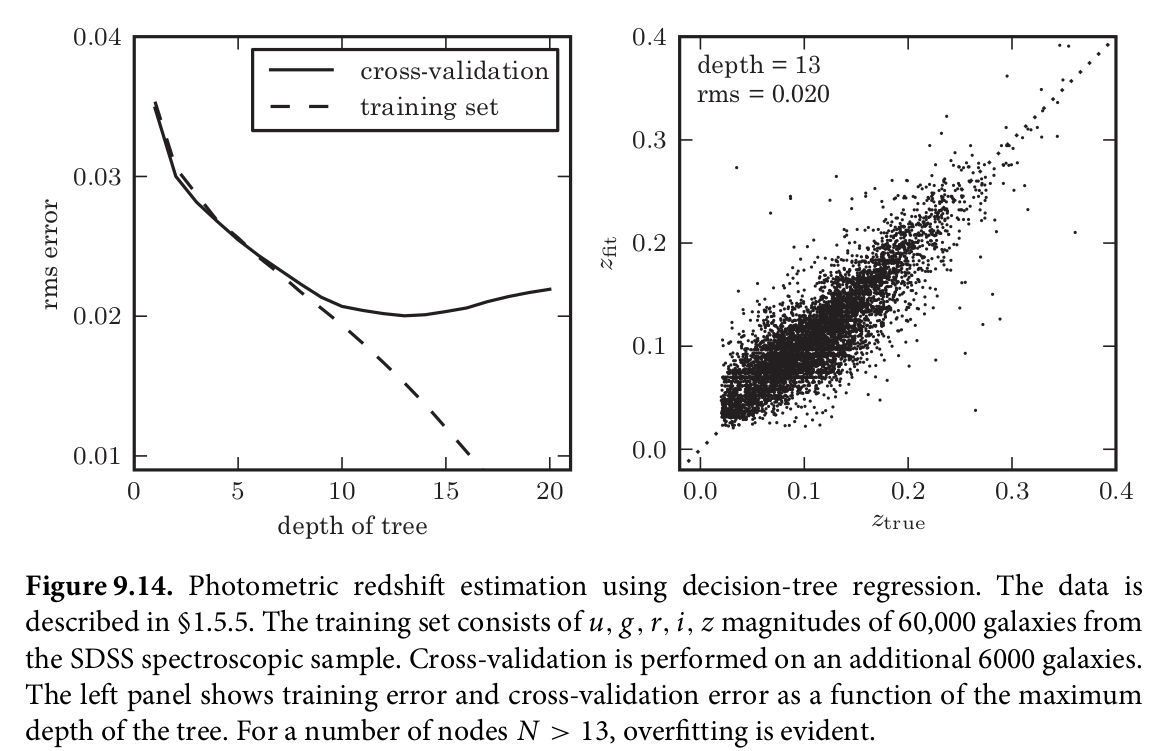

<div align="right"> Credit: Ivezic et al. 2014 </div>

### Prunning

A second approach is to **pruning** the tree is using cross-validation. 

For each node we consider whether terminating the tree at that node improves the accuracy in the validation set. 

If so, we prune the branches below that node

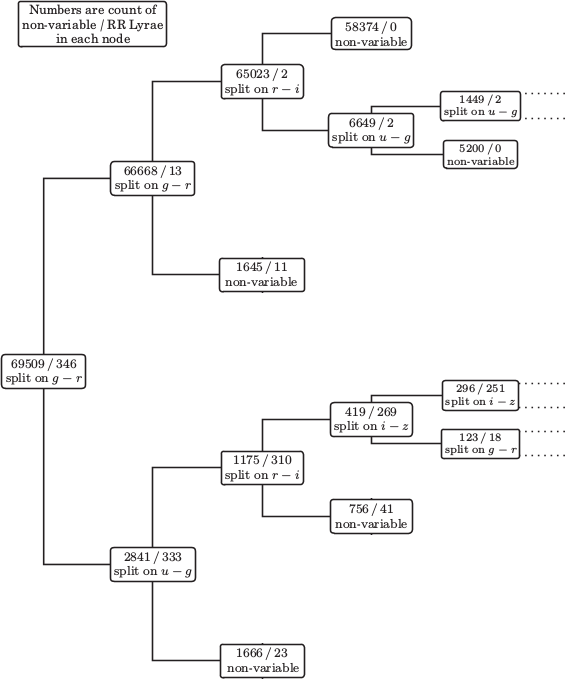![](images/tree_pruned.png)

### Missing data

Decision trees can handle missing data. For every split, one can build surrogate splits, made from the variables and split values whose result most resemble the result from the main split. For a moderate fraction of missing data this can work as well as imputation.

# Bagging and Random forests

A different approach for classification is that of *ensemble learning*: combining the output of several models through some kind of voting or averaging.

It is important to remind us about the concept of **bootstrapping**, which consists of randomly sampling from data **with replacement**, i.e. we can get the same data point more than once when sampling.

In [79]:
data = np.arange(10)
data

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [80]:
np.random.choice(data, 10, replace=True)

array([1, 6, 3, 4, 6, 7, 1, 8, 2, 2])

In one dimension, bootstrapping is equivalent to sample from the empirical distribution function of the data.

In [81]:
from statsmodels.distributions.empirical_distribution import ECDF

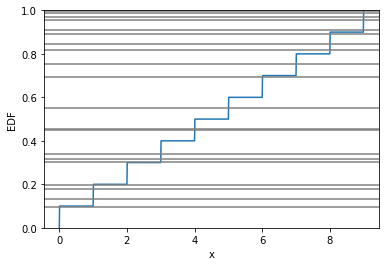

In [84]:
ecdf = ECDF(data)
fig, ax = plt.subplots()
xs = np.linspace(-1e-10, 9, 1000)
ax.plot(xs, ecdf(xs))
ax.set_ylim(0, 1)
ax.set_xlabel("x")
ax.set_ylabel("EDF")
for i in range(20):
  ax.axhline(np.random.random(), c='gray')

## Bagging

In **bagging** we take averages over the prediction of a series of **bootstrap** samples from the training set. Bagging is short for bootstrap + aggregating.


For a sample of N points in a training set, bagging generates $K$ equally sized bootstrap samples from which to estimate a function $f_i(x)$. The final estimator is then:

$\Large f(x) = \frac{1}{K} \sum\limits_i^K f_i(x)$

## Random forests

In **random forests** this concept is expanded even further by generating a **set of decision trees** from the bootstrap samples with a **random set of features**.

Random forests contain $n$ trees and $m$ randomly selected features used per tree. Keeping $m$ small compared to the number of features controls the complexity of the model and reduces over-fitting.

Random forests and its derivatives are usually the best classifiers available for feature based classification.

![](images/RF.jpg)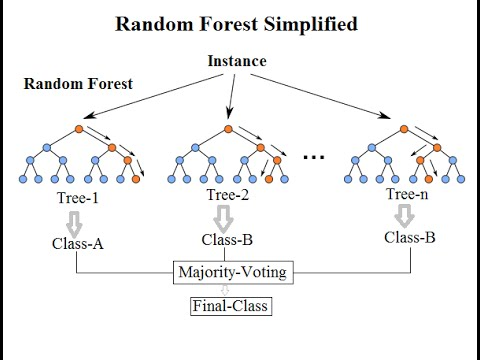

<div align='right'> Credit: Wikipedia </div>

- In random forests, the number of trees, the depth of the trees, and the number of features per tree, $m$, can be chosen via cross-validation.

- $m$ is usually chosen to be $\sim \sqrt{K}$, where $K$ is the number of features.

### Out-of-bag metrics

One of the nice features of random forests is that we can also report **out-of-bag (oob)** metrics, which are the metrics computed over points which were not used in the bootstrap sample used to train a specific tree.

### Feature importance

We can compute the change in entropy, gini index change or misclassification error summed over specific features of the tree, then average over all trees in the case of random forests.

This means that we can estimate the **feature importance** over all features.

### No need for scaling your data

Another nice feature of trees in general is the fact that the method is independent of any metric. You don't need to scale your features (although in general it is good practice to do so).

### Missing data

Unlike decision trees, one cannot always find surrogate splits. This is because for every tree you take a subsample of variables, which could be all missing from one sample.

### Random forests in scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

The most important options in sklearn are:

- `n_estimators`: the number of trees (default=10).

- `criterion`: the function used to split the tree (default='gini', better use 'entropy').

- `max_depth`: maximum depth of the tree (default=None).

Then we also have:

- `max_features`: the number of features to consider when looking for the best split (int, **"auto"**, "sqrt", "log2", None). Note that auto=sqrt.

- `min_samples_split`: the minimum number of samples required to split a node (default=2).

- `min_samples_leaf`: the minimum number of samples required to be at a leaf node (default=1).

- `n_jobs`: number of parallel cores to use during computation.

- `oob_score`: whether to use out-of-bag samples to estimates the generalization accuracy.

- `class_weight`: weights associated with classes in the form `{class_label: weight}` (default=None). If not given, all classes are assumed to have weight one. Can give dictionary of weights, or 'balanced' for inverse class frequency weighting, or 'balanced_subsample' for inverse class frequency weighting inside each bootstrap sample.

- `ccp_alpha`: complexity parameter used for Minimal Cost-Complexity Pruning (default=0).

When the tree has been trained, we can extract:

- `estimators_`: the collection of fitted sub-estimators

- `feature_importances_`: the importance of each feature.

- `oob_score`: the chosen metric over out-of-bag estimates.

**Some considerations**

- when the number of features is large and the number of relevant features is small, the random forest may perform poorly (the chances of selecting a relevant feature in each split will be low)

- increasing the number of trees generally does not lead to over-fitting

Let's try this with real data

# Some useful functions

In [14]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [16]:
def plot_contours(ax, clf, xx, yy, pos_label, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) == pos_label
    print(Z.shape)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# The SDSS QSOs and stars datasets

Download files SDSS_stars.csv and SDSS_QSO.dat from https://astrostatistics.psu.edu/MSMA/datasets/

In [86]:
!wget --no-check-certificate https://astrostatistics.psu.edu/MSMA/datasets/SDSS_QSO.dat
!wget --no-check-certificate https://astrostatistics.psu.edu/MSMA/datasets/SDSS_stars.csv

--2021-08-03 02:33:22--  https://astrostatistics.psu.edu/MSMA/datasets/SDSS_QSO.dat
Resolving astrostatistics.psu.edu (astrostatistics.psu.edu)... 168.62.182.234
Connecting to astrostatistics.psu.edu (astrostatistics.psu.edu)|168.62.182.234|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 8749579 (8.3M)
Saving to: ‘SDSS_QSO.dat.3’

SDSS_QSO.dat.3      100%[===================>]   8.34M  42.3MB/s    in 0.2s    

2021-08-03 02:33:23 (42.3 MB/s) - ‘SDSS_QSO.dat.3’ saved [8749579/8749579]

--2021-08-03 02:33:23--  https://astrostatistics.psu.edu/MSMA/datasets/SDSS_stars.csv
Resolving astrostatistics.psu.edu (astrostatistics.psu.edu)... 168.62.182.234
Connecting to astrostatistics.psu.edu (astrostatistics.psu.edu)|168.62.182.234|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 366181 (358K) [text/csv]
Saving to: ‘SDSS_stars.csv.3’

SDSS_star

In [87]:
stars = pd.read_csv("SDSS_stars.csv")
stars.head()

u_mag      g_mag      r_mag      i_mag      z_mag          ra        dec
0  20.533161  17.968031  16.827314  16.373095  16.091063  190.001261  21.910620
1  18.894476  17.674576  17.208895  17.033516  16.972940  190.002330  21.874641
2  18.290901  17.022612  16.625498  16.431305  16.399673  190.012240  21.702999
3  19.784182  17.820679  17.003235  16.721306  16.541569  190.012912  23.667913
4  18.874607  17.638632  17.120625  16.907972  16.849592  190.012951  24.797507

In [88]:
stars.shape

(5000, 7)

In [89]:
QSOs = pd.read_csv("SDSS_QSO.dat", sep = "\s+", index_col = "SDSS")
QSOs.head()

z   u_mag  sig_u_mag  ...  FIRST  ROSAT      Mp
SDSS                                           ...                      
000006.53+003055.2  1.8227  20.389      0.066  ...    0.0   -9.0 -25.100
000008.13+001634.6  1.8365  20.233      0.054  ...    0.0   -9.0 -25.738
000009.26+151754.5  1.1986  19.921      0.042  ...   -1.0   -9.0 -25.085
000009.38+135618.4  2.2400  19.218      0.026  ...   -1.0   -9.0 -27.419
000009.42-102751.9  1.8442  19.249      0.036  ...    0.0   -9.0 -26.459

[5 rows x 14 columns]

In [90]:
QSOs.shape

(77429, 14)

Create labels

In [91]:
stars["cat"] = "star"
stars["u-g"] = stars.u_mag - stars.g_mag
stars["g-r"] = stars.g_mag - stars.r_mag
stars["r-i"] = stars.r_mag - stars.i_mag
stars["i-z"] = stars.i_mag - stars.z_mag
QSOs["cat"] = "QSO"
QSOs["u-g"] = QSOs.u_mag - QSOs.g_mag
QSOs["g-r"] = QSOs.g_mag - QSOs.r_mag
QSOs["r-i"] = QSOs.r_mag - QSOs.i_mag
QSOs["i-z"] = QSOs.i_mag - QSOs.z_mag

Create new pandas dataframe with both classes, we will downsample the QSO dataset.

In [92]:
sel_cols = ["u-g", "g-r", "r-i", "i-z", "cat"]
data = pd.concat([stars[sel_cols], QSOs[sel_cols].sample(5000, random_state=1)])
#data = pd.concat([stars[sel_cols], QSOs[sel_cols]])
data["cat"] = data["cat"].astype("category")
data.sample(10)

u-g       g-r       r-i       i-z   cat
091017.07+060238.6  0.259000  0.684000  0.333000  0.425000   QSO
2846                2.573326  1.338161  0.617633  0.372628  star
151154.03-002203.6  0.584000  0.430000  0.073000  0.249000   QSO
1145                1.159134  0.468797  0.179402  0.144556  star
114242.61+494050.9  0.600000  0.057000  0.018000  0.002000   QSO
3470                1.240658  0.468907  0.142522  0.059514  star
082221.22+214410.5  0.744000  0.244000  0.031000  0.103000   QSO
143748.28-014710.7  0.097000  0.279000  0.057000  0.005000   QSO
163743.77+254430.2  2.162000  0.174000  0.081000 -0.123000   QSO
4285                1.567486  0.536773  0.245135  0.013099  star

In [93]:
data.describe()

u-g           g-r           r-i           i-z
count  10000.000000  10000.000000  10000.000000  10000.000000
mean       1.010137      0.414540      0.189363      0.097959
std        0.854551      0.365459      0.165465      0.136311
min       -2.585000     -0.561000     -1.072549     -1.085000
25%        0.250000      0.151000      0.103000      0.021000
50%        0.993799      0.366831      0.178163      0.082000
75%        1.494916      0.569775      0.262000      0.161670
max        5.645000      4.381000      1.929000      1.318122

In [94]:
data.groupby("cat").count()

u-g   g-r   r-i   i-z
cat                         
QSO   5000  5000  5000  5000
star  5000  5000  5000  5000

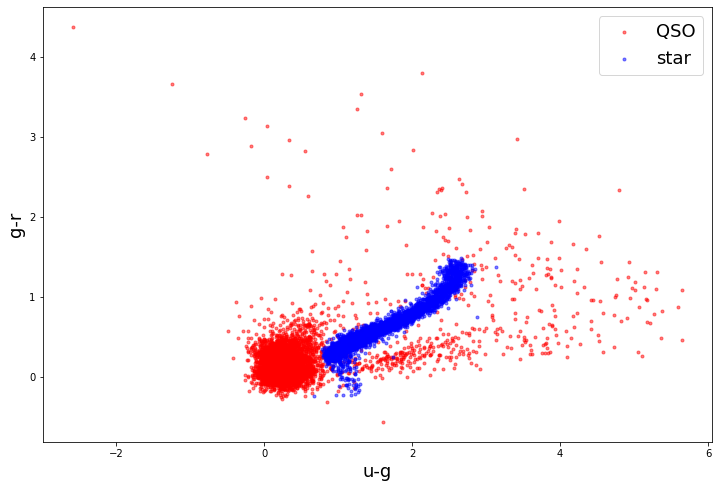

In [95]:
fig, ax = plt.subplots(figsize=(12, 8))

colors = {"QSO": 'r', "star": 'b'}
for cl in colors.keys():
    ax.scatter(data.loc[data.cat == cl]["u-g"], data.loc[data.cat == cl]["g-r"], marker='.', alpha=0.5, label=cl, color=colors[cl])
ax.set_xlabel("u-g", fontsize=18)
ax.set_ylabel("g-r", fontsize=18)
ax.legend(fontsize=18)

## Train test split

Let's try this in the stars vs QSOs dataset

In [96]:
X_train, X_test, y_train, y_test = train_test_split(data[["u-g", "g-r"]], data.cat, test_size=.4, random_state=42)

In [98]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(criterion='entropy', n_estimators=1000, oob_score=True, n_jobs=8)#, class_weight='balanced')
y_pred = rfc.fit(X_train, y_train).predict(X_test)
print("Out-of-bag score:", rfc.oob_score_)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("f1-score:", metrics.f1_score(y_test, y_pred, pos_label="QSO"))
print("Feature importance:", dict(zip(list(X_train), rfc.feature_importances_)))

Out-of-bag score: 0.9846666666666667
Accuracy: 0.987
f1-score: 0.9865424430641822
Feature importance: {'u-g': 0.6824988016465079, 'g-r': 0.3175011983534921}


Normalized confusion matrix


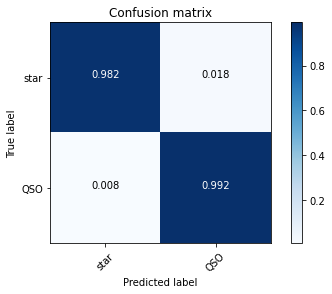

In [29]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred), ["star", "QSO"], normalize=True)

(178176,)


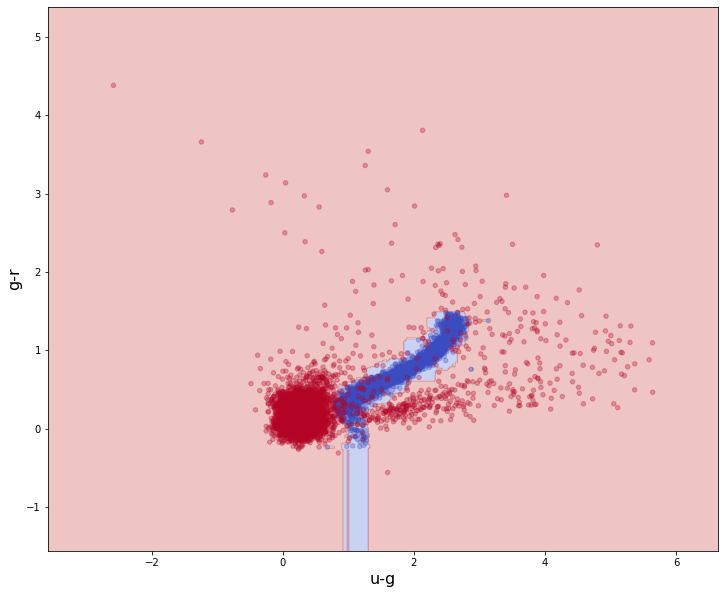

In [30]:
fig, ax = plt.subplots(figsize = (12, 10))
xx, yy = make_meshgrid(data["u-g"], data["g-r"])
plot_contours(ax, rfc, xx, yy, "QSO",
                  cmap=plt.cm.coolwarm, alpha=0.3)
ax.scatter(data["u-g"], data["g-r"], c=(data.cat=='QSO'), cmap=plt.cm.coolwarm, s=20, edgecolors=None, alpha = 0.3)
ax.set_xlabel("u-g", fontsize=16)
ax.set_ylabel("g-r", fontsize=16)
#ax.set_xlim(-2, 6)
#ax.set_ylim(-2, 6)
plt.savefig("boundary_non_weighted.png")

Let's now consider all the variables

In [99]:
X_train, X_test, y_train, y_test = train_test_split(data[["u-g", "g-r", "r-i", "i-z"]], data.cat, test_size=.4, random_state=42)

In [100]:
rfc = RandomForestClassifier(criterion='entropy', n_estimators=1000, oob_score=True, n_jobs=8)#, class_weight='balanced')
y_pred = rfc.fit(X_train, y_train).predict(X_test)
print("Out-of-bag score:", rfc.oob_score_)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("f1-score:", metrics.f1_score(y_test, y_pred, pos_label="QSO"))
print("Feature importance:", dict(zip(list(X_train), rfc.feature_importances_)))

Out-of-bag score: 0.9921666666666666
Accuracy: 0.994
f1-score: 0.9937952430196484
Feature importance: {'u-g': 0.6556456555158046, 'g-r': 0.21794845971568103, 'r-i': 0.07536456924342787, 'i-z': 0.05104131552508639}


Normalized confusion matrix


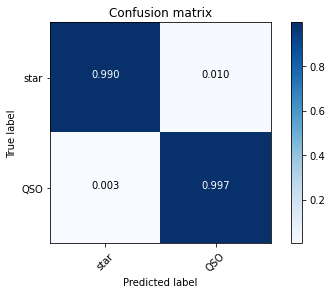

In [33]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred), ["star", "QSO"], normalize=True)

Although the feature importance of the additional variables is low, they did help us reach a very high accuracy.

## Grid search

sklearn provides some useful tools for choosing parameters via cross-validation in `GridSearchCV`

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
parameters = {'criterion': ('gini', 'entropy'), 
              'n_estimators': (5, 10, 20, 100),
              'max_depth': (20, 40)}
rfc = RandomForestClassifier(n_jobs=1, class_weight='balanced')
clf = GridSearchCV(rfc, parameters, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=1,
                                              oob_score=False,
                                              ra

In [36]:
clf.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                        oob_score=False, random_state=None, verbose=0,
                        warm_start=False),
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': 'balanced',
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimato

In [37]:
print(clf.best_params_)

{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 100}


In [38]:
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("f1-score:", metrics.f1_score(y_test, y_pred, pos_label="QSO"))

Accuracy: 0.99325
f1-score: 0.9930178432893717


# Boosting

In **boosting** the samples are weighted by the misclassification error, emphasizing the most difficult cases.

It is motivated by the idea that combining many weak classifiers can result in improved classification

Rather than creating models separately on different data sets, boosting creates each model to attempt to correct the errors of the ensemble.

The central idea is to reweight the data based on how incorrectly the data were classified in the previous iteration.

Imagine that we had a weak classifier, $h(x)$, that we wish to apply to a data set and we want to create a strong classifier, $f(x)$, such that:

$\Large f(x) = \sum\limits_m^K \theta_m h_m(x)$

where $\theta_m$ is the weigth of the m-th iteration of the classifier.

If we start with some data $X$ with known classifications $y$, we can assign a weight, $w_m(x)$ to each point (initially uniform). 

After the application of the weak classifier, $h_m(x)$, we can estimate the classification error, $e_m$, as:

$\Large e_m = \sum\limits_{i=1}^N w_m(x_i) I(h_m(x_i) \ne y_i)$

where $I(h_m(x_i) \ne y_i)$ is 1 for $h_m(x_i) \ne y_i$ and 0 otherwise.

From this we define the weight $\theta_m$:

$\Large \theta_m = \frac{1}{2} \log \biggl(\frac{1 - e_m}{e_m} \biggr)$

and update the weights for each point:

$\Large w_{m+1}(x_i) = w_m(x_i) ~\times ~ \biggr\lbrace\begin{array}{lr}
\exp(-\theta_m) & h_m(x_i) = y_i \\
\exp(\theta_m) & h_m(x_i) \ne y_i
\end{array}$

This algorithm is known as **AdaBoost**, see https://en.wikipedia.org/wiki/AdaBoost

A problem with boosted decision trees is that since they run serially they cannot be easily parallelized.

Let's try it on the QSO vs stars dataset

In [39]:
X_train, X_test, y_train, y_test = train_test_split(data[["u-g", "g-r"]], data.cat, test_size=.4, random_state=42)

In [40]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
y_pred = abc.fit(X_train, y_train).predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("f1-score:", metrics.f1_score(y_test, y_pred, pos_label="QSO"))

Accuracy: 0.97025
f1-score: 0.9687417914368269


Normalized confusion matrix


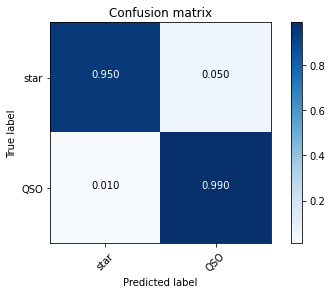

In [41]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred), ["star", "QSO"], normalize=True)

(178176,)


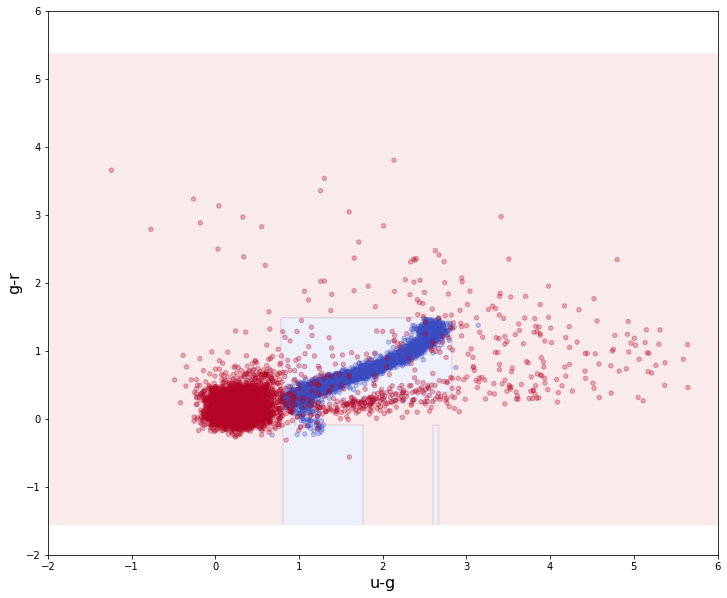

In [42]:
fig, ax = plt.subplots(figsize = (12, 10))
xx, yy = make_meshgrid(data["u-g"], data["g-r"])
plot_contours(ax, abc, xx, yy, "QSO",
                  cmap=plt.cm.coolwarm, alpha=0.1)
ax.scatter(data["u-g"], data["g-r"], c=(data.cat=='QSO'), cmap=plt.cm.coolwarm, s=20, edgecolors=None, alpha = 0.3)
ax.set_xlabel("u-g", fontsize=16)
ax.set_ylabel("g-r", fontsize=16)
ax.set_xlim(-2, 6)
ax.set_ylim(-2, 6)
plt.savefig("boundary_non_weighted.png")

# Gradient Boosting

This is a variation from AdaBoost. 

In this type of classifier we try to approximate a steepest descent criterion after each evaluation.

The basic idea is to assume that the $m+1$ classifier gives the correct classifications after applying a correction $h$ to the $m$ classifier:

$\Large F_{m+1}(x) = F_m(x) + h(x) = y$

where $F_m(x)$ is the $m$-th classifier

This implies a residual $h(x)$:

$\Large h(x) = y - F_m(x)$

The name follows from the observation that the residuals $h_m(x)$ for a given model are the negative gradients of the mean squared error loss functions w.r.t. F(x):

$\Large L_{MSE} = \frac{1}{2} (y - F_m(x))^2$

$\Large h_m(x) = \frac{- \partial L_{MSE}}{\partial F} = y - F(x)$

Note that in the case of classification the loss function is an impurity measure such as the entropy of the tree splits.

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
y_pred = gbc.fit(X_train, y_train).predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("f1-score:", metrics.f1_score(y_test, y_pred, pos_label="QSO"))

Accuracy: 0.98775
f1-score: 0.987256176853056


Normalized confusion matrix


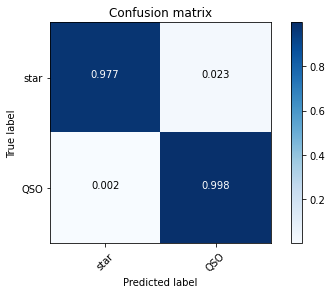

In [44]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred), ["star", "QSO"], normalize=True)

(178176,)


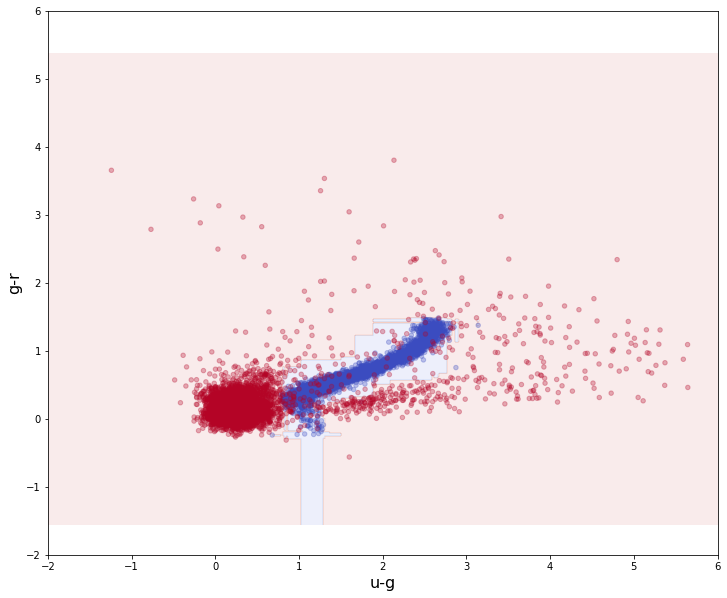

In [45]:
fig, ax = plt.subplots(figsize = (12, 10))
xx, yy = make_meshgrid(data["u-g"], data["g-r"])
plot_contours(ax, gbc, xx, yy, "QSO",
                  cmap=plt.cm.coolwarm, alpha=0.1)
ax.scatter(data["u-g"], data["g-r"], c=(data.cat=='QSO'), cmap=plt.cm.coolwarm, s=20, edgecolors=None, alpha = 0.3)
ax.set_xlabel("u-g", fontsize=16)
ax.set_ylabel("g-r", fontsize=16)
ax.set_xlim(-2, 6)
ax.set_ylim(-2, 6)
plt.savefig("boundary_non_weighted.png")

## Extreme Gradient Boosting (xgboost)

One of the most popular and successful supervised classification algorithms.

https://xgboost.ai/

Focus on speed and model performance. 

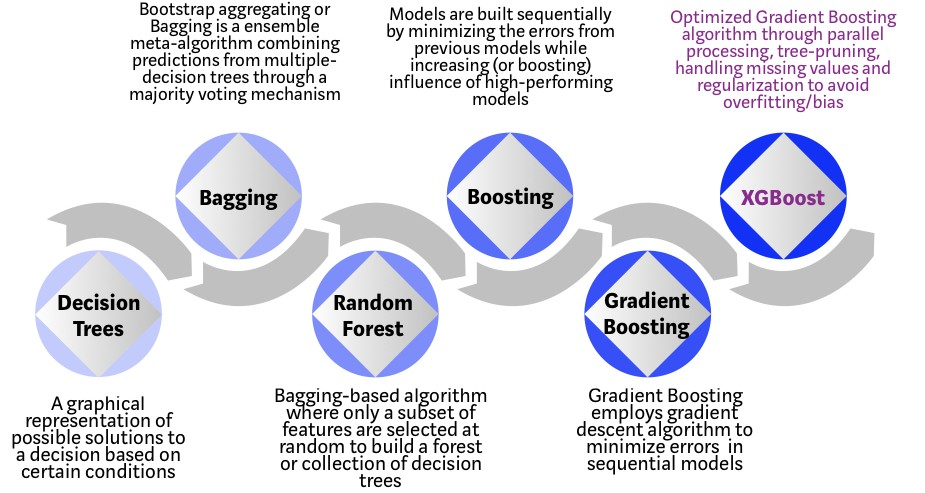

xgboost has been used by several teams wining Kaggle challenges.

One of its focus is speed:

- parallel tree computation
- tree pruning on the fly
- hardware optimization

![](images/xgboost.png)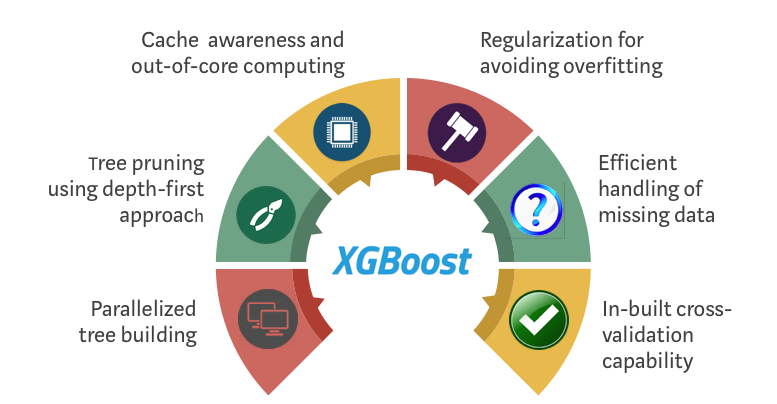

In terms of the algorithm, the following changes have been made:

- regularization via LASSO and Ridge regularization
- it accepts sparse data with missing values, by learning best missing values
- it uses **quantile sketch algorithm** to find optimal split points
- built-in cross-validation at each iteration

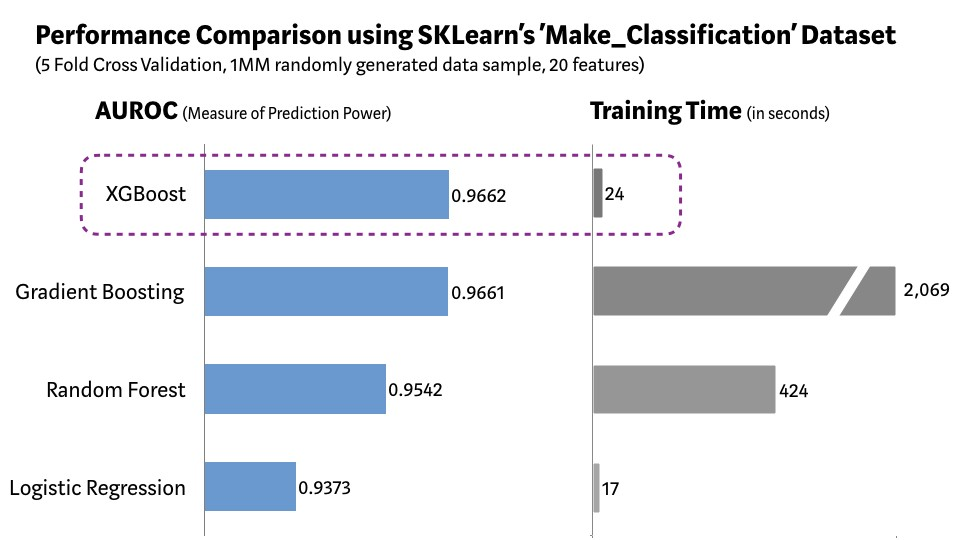

## Light Gradient Boosting Microsoft (lightGBM)

* Fast, distributed, high-preformance gradient boosting, developed by Microsoft

* LightGBM grows trees horizontally (leaf-wise) while other algorithms grow level-wise

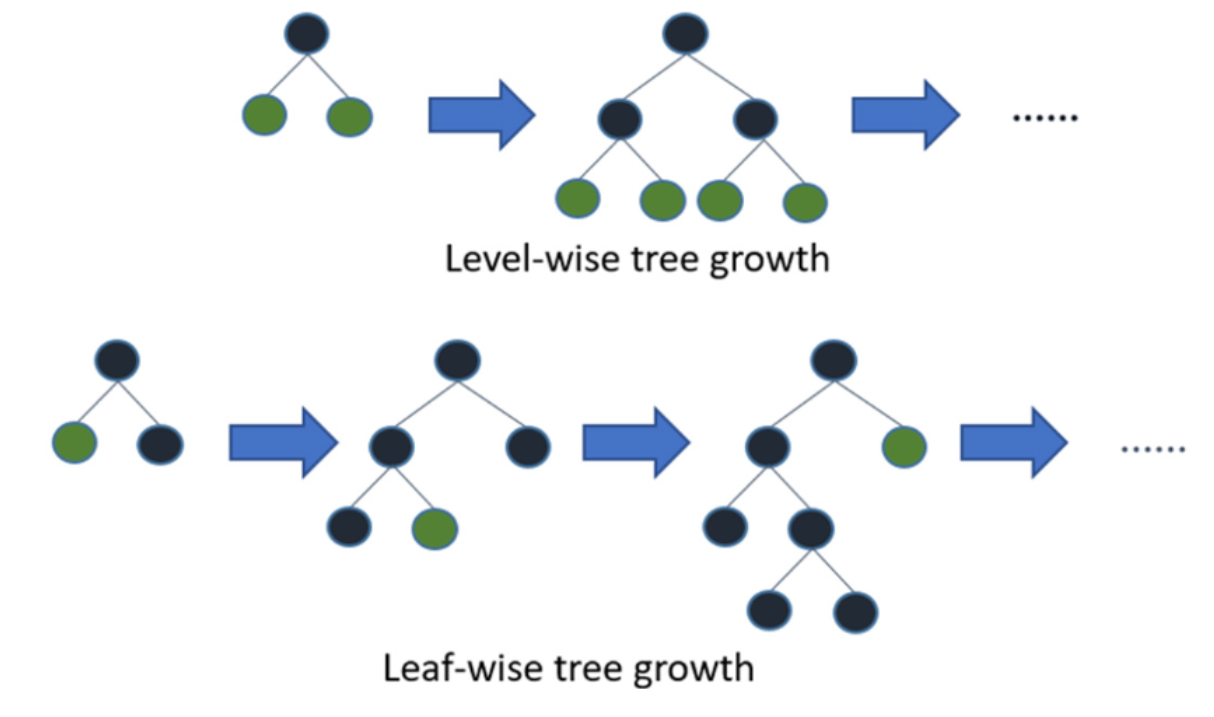

### Transform labels to numbers with LabelEncoder

In [46]:
from sklearn.preprocessing import LabelEncoder

In [47]:
y_train.head()

135048.80+392008.1     QSO
3159                  star
1489                  star
2987                  star
812                   star
Name: cat, dtype: category
Categories (2, object): ['QSO', 'star']

In [48]:
le = LabelEncoder()
le.fit(y_train)
print(le.classes_)
print(le.inverse_transform([0, 1]))
yt_train = le.transform(y_train)
yt_test = le.transform(y_test)

['QSO' 'star']
['QSO' 'star']


In [49]:
yt_train

array([0, 1, 1, ..., 0, 1, 0])

## XGBoost

In [50]:
def plot_contours_xgb(ax, xg, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = xg.predict(xgb.DMatrix(pd.DataFrame(data = np.c_[xx.ravel(), yy.ravel()], columns=["u-g", "g-r"]))) >= 0.5
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [51]:
import xgboost as xgb 

In [52]:
dtrain = xgb.DMatrix(X_train,label=yt_train)
dtest = xgb.DMatrix(X_test)

In [53]:
#setting parameters for xgboost
parameters={'max_depth':7, 'eta':1, 'silent':1,'objective':'binary:logistic','eval_metric':'auc','learning_rate':.05}

In [54]:
num_round = 50 
xg = xgb.train(parameters,dtrain,num_round) 

In [55]:
xg.predict(dtest)

array([0.04075164, 0.9467968 , 0.933916  , ..., 0.9467968 , 0.04075164,
       0.933916  ], dtype=float32)

In [56]:
y_pred = np.array(xg.predict(dtest) >= 0.5, dtype=int)
y_pred

array([0, 1, 1, ..., 1, 0, 1])

Normalized confusion matrix


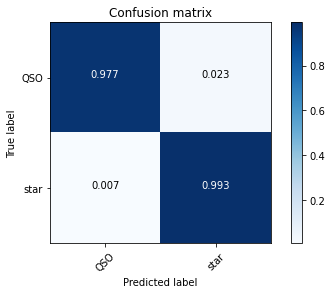

In [57]:
plot_confusion_matrix(metrics.confusion_matrix(np.array(yt_test), y_pred, le.transform(["QSO", "star"])), ["QSO", "star"], normalize=True)

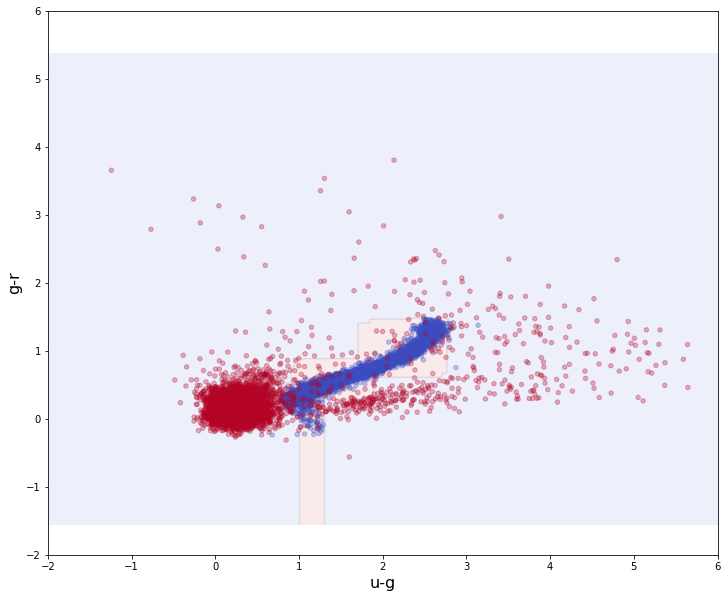

In [58]:
fig, ax = plt.subplots(figsize = (12, 10))
xx, yy = make_meshgrid(data["u-g"], data["g-r"])
plot_contours_xgb(ax, xg, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.1)
ax.scatter(data["u-g"], data["g-r"], c=(data.cat=='QSO'), cmap=plt.cm.coolwarm, s=20, edgecolors=None, alpha = 0.3)
ax.set_xlabel("u-g", fontsize=16)
ax.set_ylabel("g-r", fontsize=16)
ax.set_xlim(-2, 6)
ax.set_ylim(-2, 6)
plt.savefig("boundary_non_weighted.png")

## LightGBM

In [59]:
def plot_contours_lgm(ax, bst, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = bst.predict(np.c_[xx.ravel(), yy.ravel()]) >= 0.5
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [60]:
import lightgbm as lgb

In [61]:
train_data = lgb.Dataset(X_train, label=yt_train)

In [62]:
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200, 'is_unbalanced':True}
param['metric'] = 'auc'

In [63]:
num_round = 10
bst = lgb.train(param, train_data, num_round)

In [64]:
lgb.cv(param, train_data, num_round, nfold=5)

{'auc-mean': [0.9851152183586717,
  0.9851129952472049,
  0.9865421781024697,
  0.9867322426776918,
  0.9877201288314428,
  0.9883906735844203,
  0.98833092716183,
  0.9884337462447699,
  0.9889322516408254,
  0.9894257623176745],
 'auc-stdv': [0.004132367955110743,
  0.004135929834503057,
  0.003625246341558403,
  0.003481798800555565,
  0.0037002363547074383,
  0.004227656863411387,
  0.004192601903589178,
  0.004326633350214428,
  0.0038559735891877723,
  0.0037985764553112333]}

In [65]:
y_pred = np.array(bst.predict(X_test) >= 0.5, dtype=int)

Normalized confusion matrix


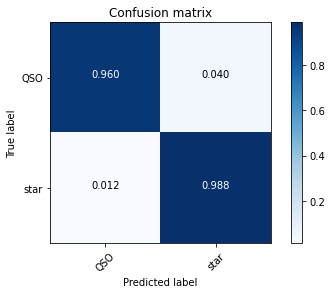

In [66]:
plot_confusion_matrix(metrics.confusion_matrix(np.array(yt_test), y_pred, le.transform(["QSO", "star"])), ["QSO", "star"], normalize=True)

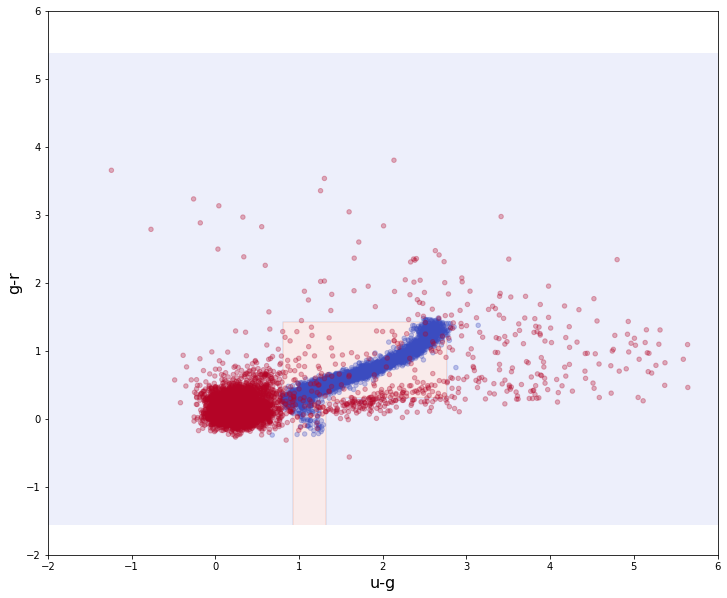

In [67]:
fig, ax = plt.subplots(figsize = (12, 10))
xx, yy = make_meshgrid(data["u-g"], data["g-r"])
plot_contours_lgm(ax, bst, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.1)
ax.scatter(data["u-g"], data["g-r"], c=(data.cat=='QSO'), cmap=plt.cm.coolwarm, s=20, edgecolors=None, alpha = 0.3)
ax.set_xlabel("u-g", fontsize=16)
ax.set_ylabel("g-r", fontsize=16)
ax.set_xlim(-2, 6)
ax.set_ylim(-2, 6)
plt.savefig("boundary_non_weighted.png")

# Imbalanced data sets

## Reload data set

We will reload the dataset and make it intentionally highly imbalanced.

In [68]:
sel_cols = ["u-g", "g-r", "r-i", "i-z", "cat"]
data = pd.concat([stars[sel_cols].sample(100), QSOs[sel_cols].sample(4000)])
data["cat"] = data["cat"].astype("category")
data.sample(10)

u-g       g-r       r-i      i-z   cat
1060                1.986349  0.831988  0.322254  0.12557  star
094108.46+320820.7  0.298000  0.116000  0.138000 -0.02700   QSO
112846.23+441902.3  2.958000  0.717000  0.117000  0.10700   QSO
095549.51+370430.7  0.107000  0.037000  0.193000 -0.04900   QSO
080620.01+423124.2  1.108000  0.373000  0.165000  0.38700   QSO
110910.54+022212.9 -0.024000  0.520000  0.039000  0.03700   QSO
133814.50+394741.7  0.197000 -0.075000  0.249000 -0.17300   QSO
080311.84+335916.0  0.128000  0.299000 -0.031000 -0.06200   QSO
160137.90+172851.0  0.404000  0.053000  0.093000  0.19300   QSO
123105.07+013140.0 -0.058000  0.071000  0.190000  0.17500   QSO

In [69]:
data.describe()

u-g          g-r          r-i          i-z
count  4100.000000  4100.000000  4100.000000  4100.000000
mean      0.479606     0.227443     0.148207     0.085520
std       0.848514     0.319212     0.176084     0.165197
min     -19.297000    -0.287000    -0.315000    -1.085000
25%       0.123000     0.053000     0.029000    -0.022000
50%       0.249000     0.161000     0.142000     0.064000
75%       0.445000     0.302000     0.243000     0.178000
max       5.613000     4.035000     2.230000     1.286000

In [70]:
data.groupby("cat").count()

u-g   g-r   r-i   i-z
cat                         
QSO   4000  4000  4000  4000
star   100   100   100   100

In [71]:
X_train, X_test, y_train, y_test = train_test_split(data[["u-g", "g-r"]], data.cat, test_size=.4)

In [72]:
np.unique(y_train, return_counts=True)

(array(['QSO', 'star'], dtype=object), array([2402,   58]))

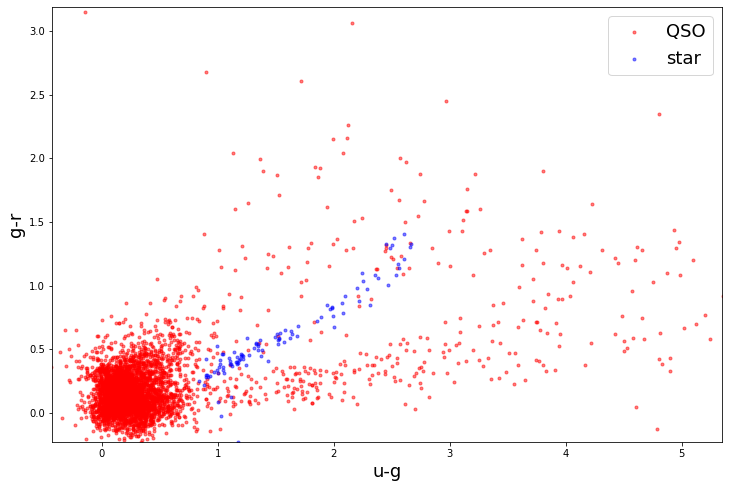

In [73]:
fig, ax = plt.subplots(figsize=(12, 8))

colors = {"QSO": 'r', "star": 'b'}
for cl in colors.keys():
    ax.scatter(data.loc[data.cat == cl]["u-g"], data.loc[data.cat == cl]["g-r"], marker='.', alpha=0.5, label=cl, color=colors[cl])
ax.set_xlabel("u-g", fontsize=18)
ax.set_ylabel("g-r", fontsize=18)
ax.set_xlim(np.percentile(data["u-g"], 0.1), np.percentile(data["u-g"], 99.9))
ax.set_ylim(np.percentile(data["g-r"], 0.1), np.percentile(data["g-r"], 99.9))
ax.legend(fontsize=18)

In [74]:
rfc = RandomForestClassifier(criterion='entropy', n_estimators=1000, oob_score=True, n_jobs=8)#, class_weight='balanced')
y_pred = rfc.fit(X_train, y_train).predict(X_test)
print("Out-of-bag score:", rfc.oob_score_)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("f1-score:", metrics.f1_score(y_test, y_pred, pos_label="QSO"))
print("Feature importance:", dict(zip(list(X_train), rfc.feature_importances_)))

Out-of-bag score: 0.9829268292682927
Accuracy: 0.9871951219512195
f1-score: 0.9934477379095163
Feature importance: {'u-g': 0.6452057808639867, 'g-r': 0.3547942191360132}


Normalized confusion matrix


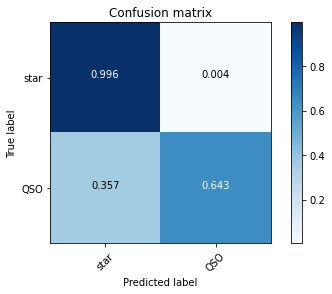

In [75]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred), ["star", "QSO"], normalize=True)

Note that the accuracy does not reflect the problems that are evident in the confusion matrix.

To address this problem a modified random forest can be built where each bootstrap sample is a balanced subsample. This is implemented in the imbalanced learn library.

https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html


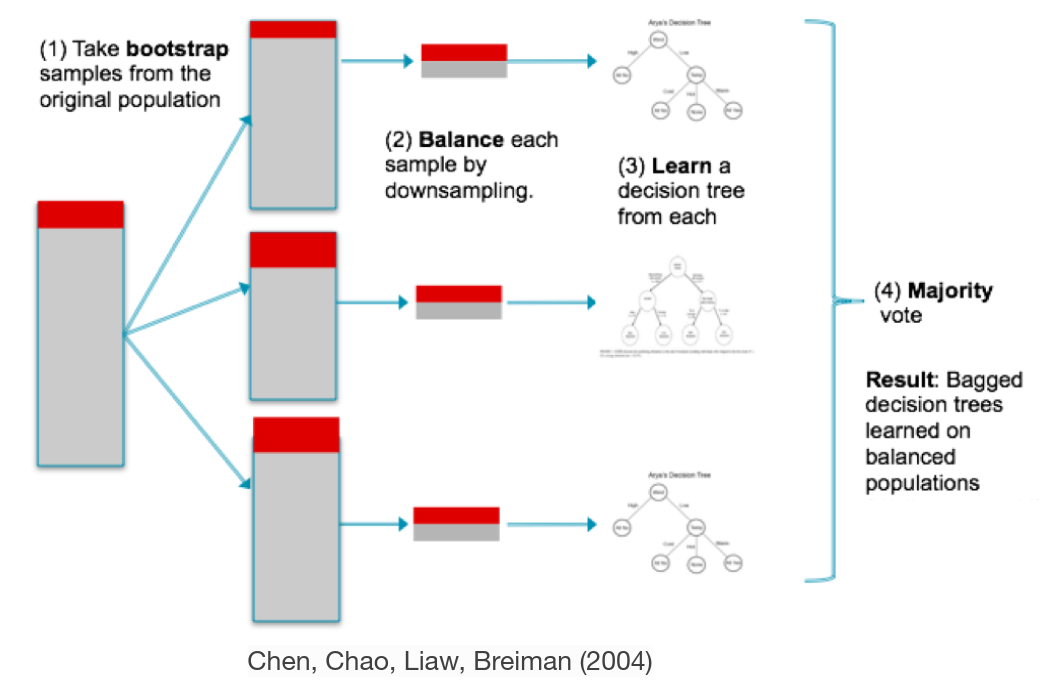

# Homework:

Can you solve the previous case by using a balanced random forest classifier?

Can you try the methods above for your favorite dataset?